In [1]:
# run case-3 

In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
import openpyxl
import traceback
import multiprocessing

In [3]:
from Fun_P3_1 import (
    recursive_scan,
    Para_init,
    Run_model_wwo_dry_out ,
    Cal_new_con_Update,
    Run_Model_Base_On_Last_Solution,
    Run_Model_Base_On_Last_Solution_RPT,
    write_excel_xlsx,)

In [4]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[8,],
   "Ageing cycles between RPT":[4,],
   "Update cycles for ageing":[2,],
   "Cycles within RPT":[2,],
   "Ageing temperature":[25,],
   "RPT temperature":[25,],
   "Particle mesh points":[30,],
   "Para_Set":[ "Chen2020",],
   "electrolyte":["lipf6_Nyman2008_rio"],
   "Model option":[
         {    
            "SEI":"solvent-diffusion limited",   
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",      
            "solvent diffusion": "EC", },
         ],

   # Solvent consumption sub-model
   "Initial electrolyte excessive amount ratio":[2.0,],
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   # solvent-diffusion limited
   'Outer SEI solvent diffusivity [m2.s-1]':[1.7e-20],

   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[1e-12,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity [m2.s-1]':[2e-20,],
   'SEI kinetic rate constant [m.s-1]':[1e-19,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})

# define experiments
V_max = 4.2;        
V_min = 2.5; 
exp_AGE_text = [(f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ]
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ (f"Discharge at 0.1C until {V_min} V",  
        "Rest for 1 hours",  
        f"Charge at 0.1C until {V_max} V" ) ]
# step index for RPT
step_RPT_CD = 0;  step_RPT_RE =1;   step_RPT_CC = 2;  

exp_text_list = [exp_AGE_text, exp_RPT_text,];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_RPT_CD,step_RPT_RE , step_RPT_CC ];



########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Total EC in electrolyte [mol]",
    "CDend Total EC in electrolyte and SEI [mol]",
    "CDend Total lithium in electrolyte [mol]",   
    #"Total lithium lost from electrolyte [mol]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",

]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

Successfully create a excel file
Confirm: using solvent-diffusion limited
Finish the break-in cycle
Succeed in 6 minutes, 32 seconds
This is the  1  scan


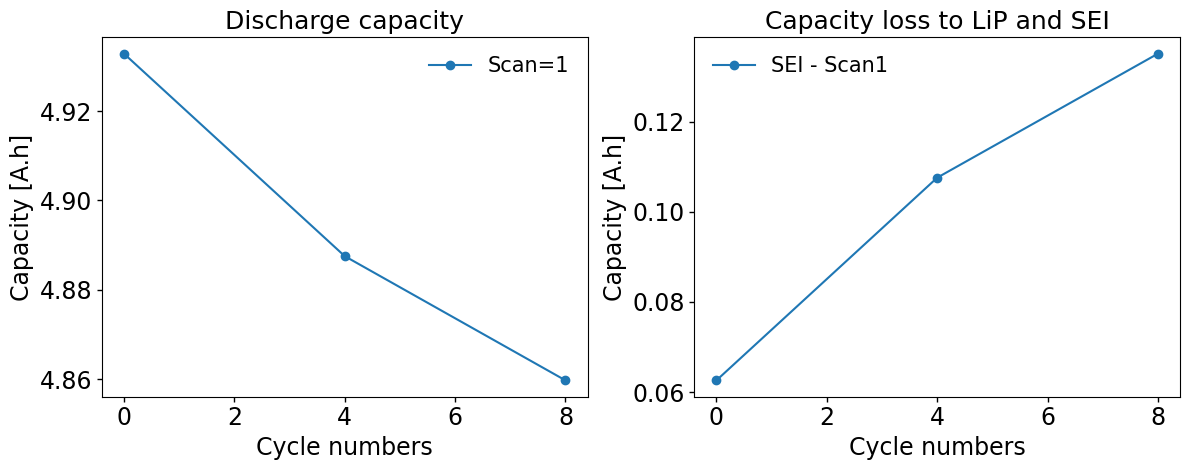

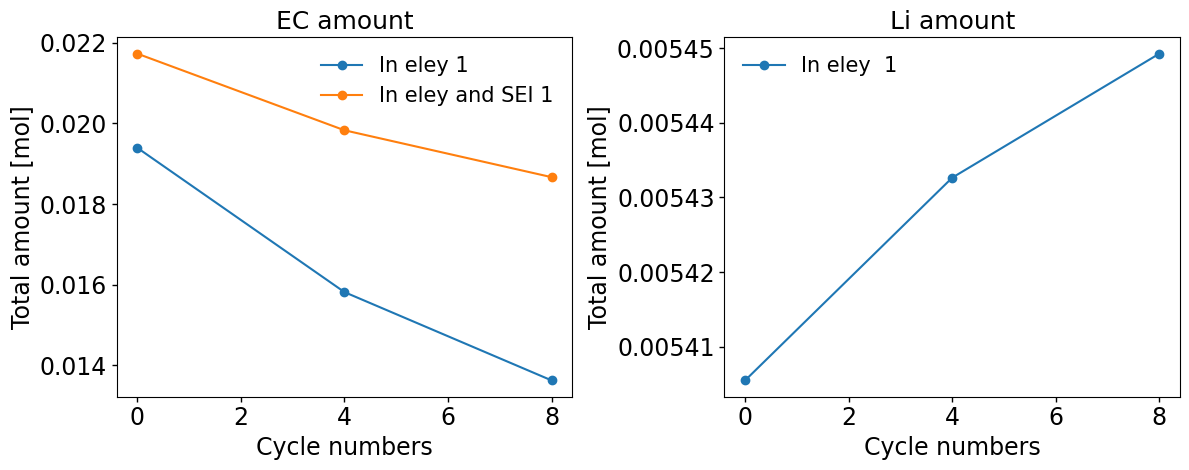

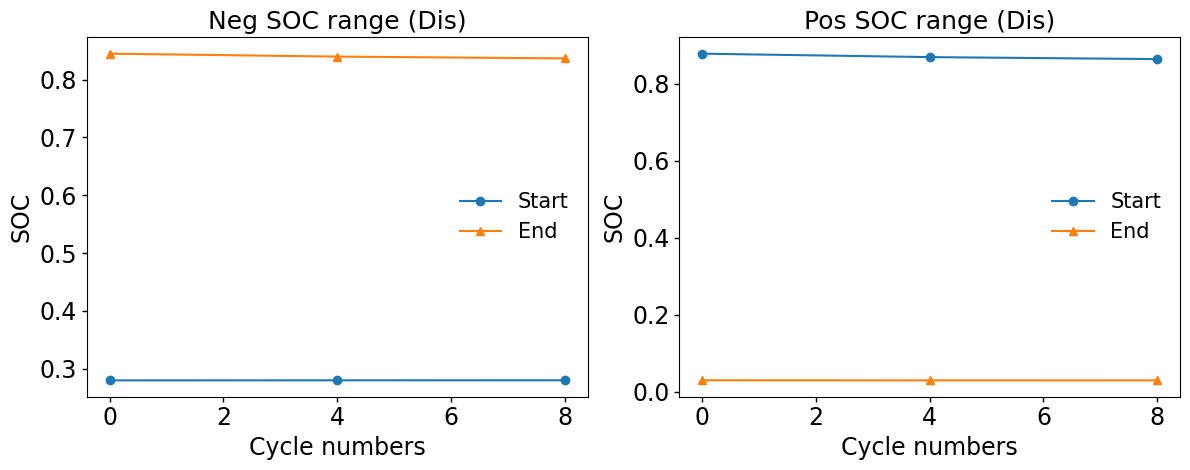

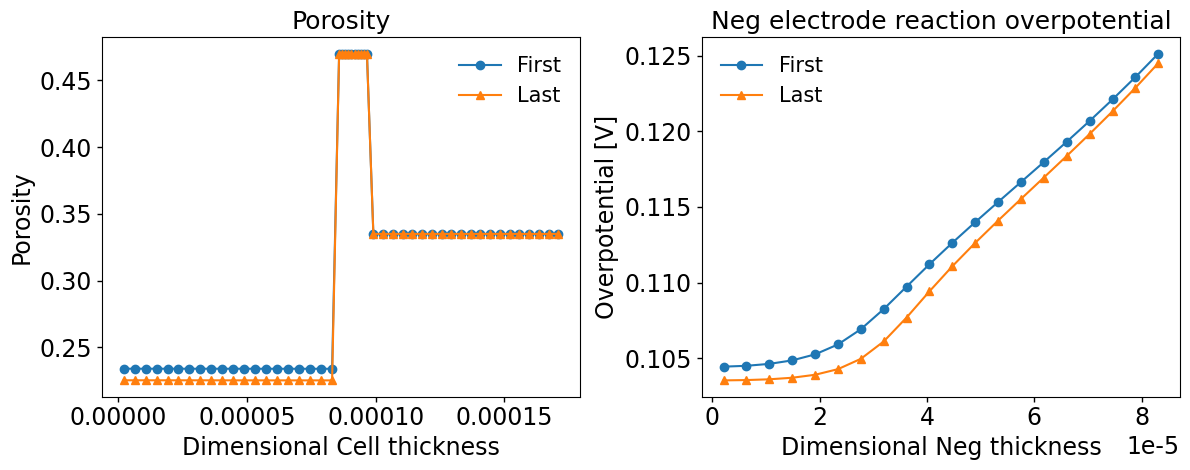

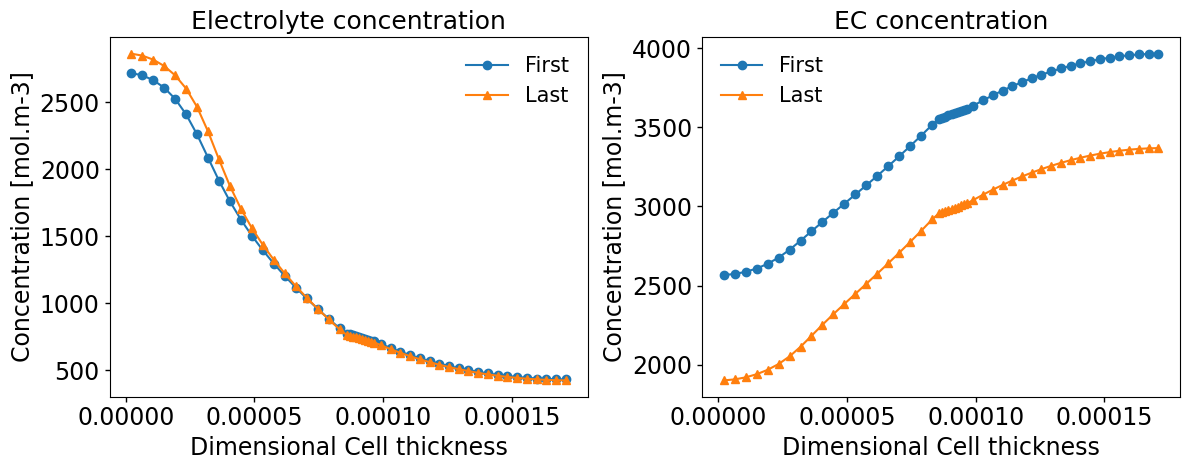

In [5]:
# Main code to run the model  'D:/OneDrive - Imperial College London/SimDataSave/P2R3/'; 
BasicPath="D:/OneDrive - Imperial College London/SimDataSave/P3R3/Test"
Target  = '/Case3/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'Solv_SEI_8cycles_10.xlsx';

sheet_name_xlsx = 'Results';

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];

# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.insert(1,"Dry out");
head_list.extend([ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"])
write_excel_xlsx(BasicPath + Target+book_name_xlsx, sheet_name_xlsx, [head_list])

index_list = np.arange(1,len(Para_dict_list)+1,1)

# scan:
DryOut = "Off"; # option: On and Off

for index_list_i, Para_dict_i in zip(index_list,Para_dict_list):
    Run_model_wwo_dry_out(
            index_list_i, Para_dict_i,   Path_pack , 
            keys_all,   exp_text_list, exp_index_pack, DryOut
        )

if __name__ == "__main__":
    pool = multiprocessing.Pool(1)
    processes = [pool.apply_async(
        Run_model_wwo_dry_out, 
        args=(
            index_list_i, Para_dict_i,   Path_pack , 
            keys_all,   exp_text_list, exp_index_pack, DryOut
        )
            ) 
            for index_list_i, Para_dict_i in zip(index_list,Para_dict_list)]
    result = [p.get() for p in processes]